# Phase 3 — Exploratory Data Analysis (EDA)


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup output folder
out_dir = Path('notebooks_output')
out_dir.mkdir(exist_ok=True)

# Load processed CSVs
co2 = pd.read_csv('../data/processed/detailed_co2.csv')
energy = pd.read_csv('../data/processed/detailed_energy.csv')
joined = pd.read_csv('../data/processed/joined_energy_co2.csv')

co2.head(), energy.head(), joined.head()

/tmp/ipykernel_52848/3659298164.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  joined = pd.read_csv('../data/processed/joined_energy_co2.csv')


(  iso_code  year  total_CO2_Mt  coal_CO2_Mt  oil_CO2_Mt  gas_CO2_Mt  \
 0      AFG  1950         0.084        0.021       0.063         0.0   
 1      AFG  1951         0.092        0.026       0.066         0.0   
 2      AFG  1952         0.092        0.032       0.060         0.0   
 3      AFG  1953         0.106        0.038       0.068         0.0   
 4      AFG  1954         0.106        0.043       0.064         0.0   
 
    cement_CO2_Mt  flaring_CO2_Mt  consumption_CO2_Mt  
 0            0.0             NaN                 NaN  
 1            0.0             NaN                 NaN  
 2            0.0             NaN                 NaN  
 3            0.0             NaN                 NaN  
 4            0.0             NaN                 NaN  ,
   iso_code        country  year  population  gdp  primary_energy_TWh  \
 0      NaN  ASEAN (Ember)  2000         NaN  NaN                 NaN   
 1      NaN  ASEAN (Ember)  2001         NaN  NaN                 NaN   
 2      Na

## Missingness Analysis

In [17]:
missingness = joined.isnull().mean().reset_index()
missingness.columns = ['column', 'missing_fraction']
missingness.to_csv(out_dir/'missingness_summary.csv', index=False)

# Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(joined.isnull(), cbar=False)
plt.title('Missingness Heatmap (joined dataset)')
plt.savefig(out_dir/'missingness_heatmap.png', bbox_inches='tight')
plt.close()
missingness.sort_values('missing_fraction', ascending=False).head(10)

,column,missing_fraction
17,consumption_CO2_Mt,0.977726
9,renewables_TWh,0.975920
6,coal_TWh,0.975920
8,gas_TWh,0.975920
7,oil_TWh,0.975920
10,electricity_TWh,0.965445
14,gas_CO2_Mt,0.963123
16,flaring_CO2_Mt,0.955755
12,coal_CO2_Mt,0.953800
5,primary_energy_TWh,0.943583


## Top 20 Emitters (most recent year)

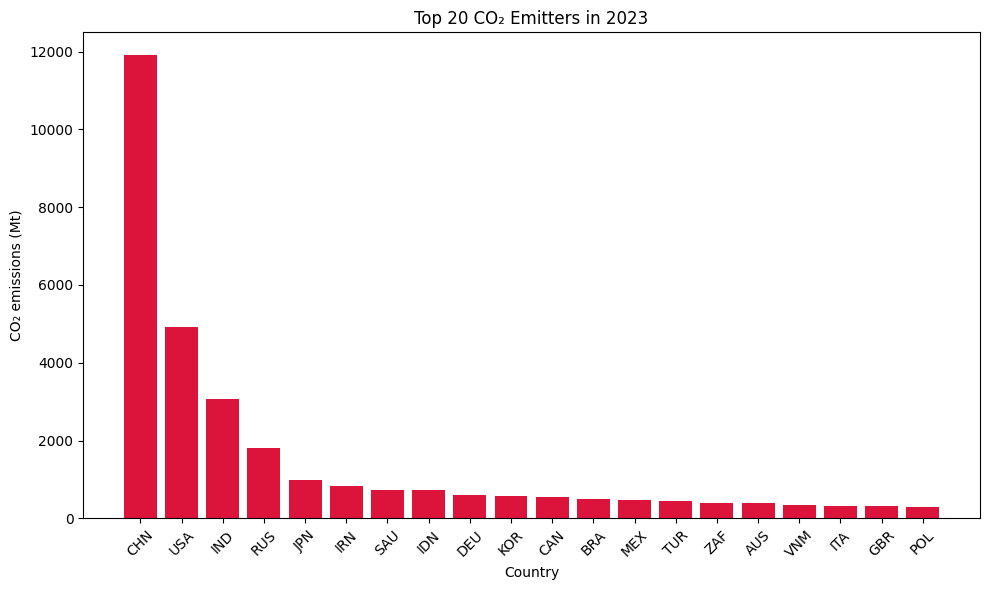

In [18]:
recent_year = co2['year'].max()

# Filter to recent year and drop rows with missing iso_code
top_emitters = (
    co2[co2['year'] == recent_year]
    .dropna(subset=['iso_code'])
    .sort_values('total_CO2_Mt', ascending=False)
    .head(20)
)

top_emitters.to_csv(out_dir / 'top20_emitters.csv', index=False)

plt.figure(figsize=(10,6))
plt.bar(top_emitters['iso_code'].astype(str), top_emitters['total_CO2_Mt'], color='crimson')
plt.xticks(rotation=45)
plt.title(f"Top 20 CO₂ Emitters in {recent_year}")
plt.ylabel("CO₂ emissions (Mt)")
plt.xlabel("Country")
plt.tight_layout()
plt.savefig(out_dir / 'top20_emitters.png')
plt.show()


## Global Energy Mix Trends

<Figure size 1200x600 with 0 Axes>

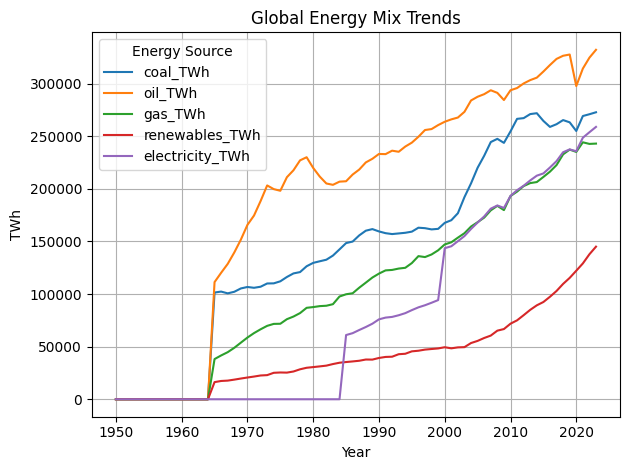

In [19]:
# List of energy columns
energy_cols = ['primary_energy_TWh','coal_TWh','oil_TWh','gas_TWh','renewables_TWh','electricity_TWh']

# Fill missing values with 0 before aggregation
energy[energy_cols] = energy[energy_cols].fillna(0)

# Aggregate global energy by year
energy_world = energy.groupby('year')[energy_cols].sum().reset_index()

# Handle population and GDP if available
if 'population' in joined.columns and 'gdp' in joined.columns:
    joined[['population', 'gdp']] = joined[['population', 'gdp']].fillna(0)
    pop_gdp = joined.groupby('year')[['population','gdp']].sum().reset_index()
    energy_world = energy_world.merge(pop_gdp, on='year', how='left')


# Plot global energy mix trends
plt.figure(figsize=(12,6))
energy_world.set_index('year')[['coal_TWh','oil_TWh','gas_TWh','renewables_TWh','electricity_TWh']].plot()
plt.title('Global Energy Mix Trends')
plt.ylabel('TWh')
plt.xlabel('Year')
plt.grid(True)
plt.legend(title='Energy Source')
plt.tight_layout()
plt.savefig(out_dir/'energy_mix_trends.png')
plt.show()